# Compute LST and NDVI in NYC for Landsat 8

## Introduction 

In this notebook, we compute LST for the New York City using *Landsat 8* data that is clipped to NYC boundaries. To compute LST, we follow the procedure outlined in Using McConnell's 2022 paper adapted for Landsat 8. The steps are 

- Convert Band 6 to Top of Atmosphere (TOA) spectral radiance using two constants from Landsat metadata
- Compute brightness temperature using TOA and 2 constants from metadata
- Compute NDVI using 
\begin{align}
\frac{\text{NIR} - \text{Red}}{\text{NIR} + \text{Red}} = \frac{\text{Band} \, 5 \, – \text{Band} \, 4}{\text{Band} \, 5 + \text{Band} \, 4} 
\end{align}
- Convert NDVI to vegetation fraction
- Compute emissivity using the formula specified in McConnell's paper
- Compute LST using brightness temperature, emissivity, and some constants also specified in McConnell's paper

The contents of this notebook are the following.

- In [Section 1](#import), we define functions to compute the outlined procedure
- In [Section 2](#test) we test the procedure on a single Landsat file and plot the result. 
- In [Section 3](#export) we compute LST and NDVI for all the Landsat files and export results. 

## Results

LST and NDVI are computed in this notebook and exported for later use. A heatmap of LST/NDVI can be generated in [Section 2](#test).

## Data

The data imported into this notebook is clipped Landsat data located in `02-data/landsat_clipped_nyc/`. These are raster files saved in `.tif` format. We import the files relevant to LST calculations with Landsat 8, which are bands 4, 5, and 10. 

Data is exported to the folders `02-data/ndvi_clipped_nyc` and `02-data/lst_clipped_nyc`. The exported filenames contain the parameter computed with the original Landsat filename. For example, the file `ndvi_LC08_L1GT_109212_20150719_20170406_01_T2.tif` contains the NDVI calculation in NYC for the Landsat file listed. 

In [1]:
import os
DIR_PARENT = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
DIR_SCRIPTS = DIR_PARENT + "/01-scripts"

"""Push the directory to load helper scripts from"""
import sys
sys.path.append(DIR_SCRIPTS)

import helpers

import rioxarray as rxr
import xarray as xr
from xarray.core.dataarray import DataArray
import numpy as np

# For plotting
import matplotlib.pyplot as plt

# Import directories
DIR_DATA = DIR_PARENT + "/02-data"
DIR_RAW_CLIPPED_NYC = DIR_PARENT + "/02-data/landsat_clipped_nyc"

# Export directories
DIR_NDVI_CLIPPED_NYC = DIR_PARENT + "/02-data/ndvi_clipped_nyc"
DIR_LST_CLIPPED_NYC = DIR_PARENT + "/02-data/lst_clipped_nyc"
DIR_FIGS = DIR_PARENT + "/03-figs"

## 1. Import data and define functions <a id="import"></a>

In [2]:
landsat_filenames = []
helpers.get_filenames(DIR_RAW_CLIPPED_NYC, landsat_filenames)
landsat_filenames.sort()

# Filter clipped Landsat files by band
band4_filenames = [x for x in landsat_filenames if ("B4" in x and "LC08" in x)]
band5_filenames = [x for x in landsat_filenames if ("B5" in x and "LC08" in x)]
band10_filenames = [x for x in landsat_filenames \
                    if ("B10" in x and "LC08" in x)]

band4_filenames.sort()
band5_filenames.sort()
band10_filenames.sort()

print("Number of B4 files = ", len(band4_filenames))
print("Number of B5 files = ", len(band5_filenames))
print("Number of B10 files = ", len(band10_filenames))

def get_landsat_identifier(bname: str) -> str:
    """
    in: name = an element of bandX_filenames, where X = 1,2,3
    out: the Landsat identifer. 
        E.g. "LT05_L1TP_014032_20110831_20160831_01_T1"
    """
    return "_".join(bname.split("/")[-1].split(".")[0].split("_")[2:-1])

def import_txt_as_dict(fname: str) -> dict:
    """
    This function imports a text file where each line is of the form
        'key1 = val1'
    as a dictionary. It splits the line at the equals sign and
    assigns key-value pairs.
    
    in: fname = filename for Landsat metadata
    out: dictionary
    """
    d = {}
    with open(fname) as f:
        for line in f:
            if len(line.split("="))>1:
                (key, val) = line.split("=")
                d[key] = val.split("\n")[0]
    return d

def open_mtl_file(bname: str) -> dict:
    """
    This function opens Landsat metadata as a dictionary.
    
    in: bname = a Landsat band filename 
    out: dictionary
    """
    dirname = "/".join(bname.split("/")[:-1])
    fileroot = get_landsat_identifier(bname)
    return import_txt_as_dict(dirname+"/"+fileroot+"_MTL"+".txt")

def open_masked_band(bname: str, mask_value: float) -> DataArray:    
    """
    This function opens the band given by `filename` masking the 
    values specified by `mask_value`
    
    in: bname = Landsat band filename (element of bandX_fileanames),
    mask_value = which is zero for all our data.
    out: a masked data array
    """
    band = rxr.open_rasterio(bname)
    data_xarray = xr.DataArray(np.ma.masked_where(band==mask_value, \
                                                  band).squeeze(),
        dims=["y","x"],
        coords={"x":band["x"].data,
               "y":band["y"].data,
               "band":1,
               "spatial_ref":0},
        attrs=band.attrs)
    data_xarray.rio.write_crs(band.rio.crs, inplace=True)
    return data_xarray

def compute_toa_radiance(band: DataArray, meta: dict) -> DataArray:
    """
    Compute Top-of-Atmosphere (TOA) radiance.
    
    in: an xarray DataArray object for the masked Landsat band 
    data, and the metadata dictionary
    out: an xarray DataArray of TOA radiance
    """
    Ml = float(meta["    RADIANCE_MULT_BAND_10 "])
    Al = float(meta["    RADIANCE_ADD_BAND_10 "])
    return Ml*band + Al

def compute_brightness_temp(toa: DataArray, meta: dict) -> DataArray:
    """
    Compute brightness temperature.
    
    in: TOA radiance and metadata for a Landsat file
    out: an xarray DataArray of the brightness temperature
    """
    K1 = float(meta["    K1_CONSTANT_BAND_10 "])
    K2 = float(meta["    K2_CONSTANT_BAND_10 "])
    return K2/np.log(K1/toa + 1)

def compute_ndvi(nir: DataArray, red: DataArray, 
                 meta: dict) -> DataArray:
    """
    in: the near-infrared and red bands of the Landsat data, and
    Landsat metadata imported as a dictionary.
    out: the NDVI 
    """
    nir_toa = compute_toa_radiance(nir, meta)
    red_toa = compute_toa_radiance(red, meta)
    return (nir_toa-red_toa)/(nir_toa+red_toa)

def compute_vegetation_fraction(ndvi: DataArray) -> DataArray:
    """
    in: the NDVI for a Landsat scene
    out: The vegetation fraction for a Landsat scene
    """
    ndvi_min = np.min(ndvi)
    ndvi_max = np.max(ndvi)
    return (ndvi-ndvi_min/(ndvi_max-ndvi_min))**2

def compute_emissivity(vf: DataArray) -> DataArray:
    """
    in: Vegetation fraction for a Landsat scene
    out: the emissivity for a Landsat scene
    """
    return 0.004*vf + 0.986481

def  compute_lst(w: float, bt: DataArray, 
                emiss: DataArray) -> DataArray:
    """
    in: w = midpoint of the thermal band converted to meters, 
    bt = brightness temperature for a Landsat scene, and emiss = 
    emissivity for a Landsat scene
    out: the LST for a Landsat scene
    """
    Q = 1.438*10**(-2)
    return bt/(1 + w*bt*np.log(emiss)/Q)

Number of B4 files =  27
Number of B5 files =  27
Number of B10 files =  27


## 2. Test the computation for a single date <a id="test"></a>

In [6]:
"""Test the program by selecting a single file"""
select = 26 # OPTIONS: Integer between 0 and (Number of Landsat files) - 1.

# Open band 10 and its metadata file
band6_test = open_masked_band(band10_filenames[select], 0.0)
mtl_test = open_mtl_file(band10_filenames[select])

# Open nir and red
band5_test = open_masked_band(band5_filenames[select], 0.0)
band4_test = open_masked_band(band4_filenames[select], 0.0)

print(band4_filenames[select])
print(band5_filenames[select])
print(band10_filenames[select])

# Begin LST equations
toa = compute_toa_radiance(band6_test, mtl_test)
bt = compute_brightness_temp(toa, mtl_test)

ndvi = compute_ndvi(band5_test, band4_test, mtl_test)

vf = compute_vegetation_fraction(ndvi)
emiss = compute_emissivity(vf)
w = 10.895*10**-6 # Middle of Band 10 wavelengths, which range 10.6-11.19 µm
lst = compute_lst(w, bt, emiss)

exportname_lst = DIR_LST_CLIPPED_NYC + "/lst_" + \
    get_landsat_identifier(band10_filenames[select])
exportname_ndvi = DIR_NDVI_CLIPPED_NYC + "/ndvi_" + \
    get_landsat_identifier(band10_filenames[select])

# Test export #####################################################
# NOTE: Running this will overwrite any data already exported
# lst.rio.to_raster(exportname_lst+".tif", driver="GTiff")
# ndvi.rio.to_raster(exportname_ndvi+".tif", driver="GTiff")

/home/aderrasc/Documents/japa_final/02-data/landsat_clipped_nyc/clipped_nyc_LC08_L1TP_014032_20210826_20210901_01_T1_B4.TIF
/home/aderrasc/Documents/japa_final/02-data/landsat_clipped_nyc/clipped_nyc_LC08_L1TP_014032_20210826_20210901_01_T1_B5.TIF
/home/aderrasc/Documents/japa_final/02-data/landsat_clipped_nyc/clipped_nyc_LC08_L1TP_014032_20210826_20210901_01_T1_B10.TIF


#### Plot results

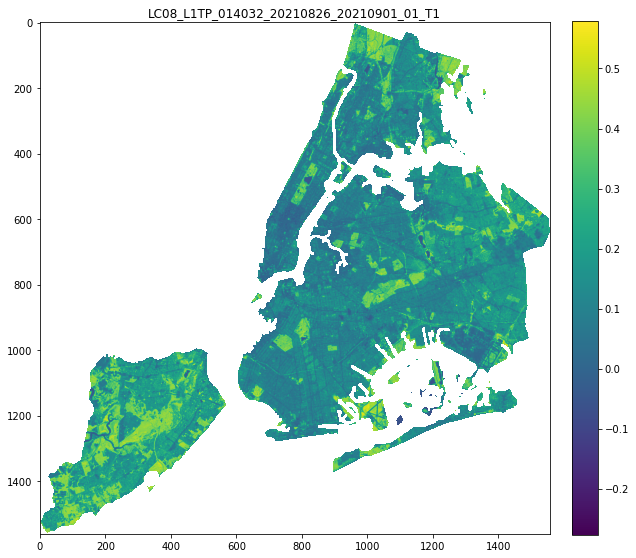

In [4]:
# Plot the test band
object_to_plot = ndvi # OPTIONS: lst, ndvi, bandX_test, toa, bt, vf, emiss
##########################################################################
fig = plt.figure(figsize=(10, 10))
im = plt.imshow(object_to_plot)#, cmap="RdYlBu")#,vmin=-1,vmax=1)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.title(get_landsat_identifier(band10_filenames[select]))
plt.savefig(DIR_FIGS + "/lst_"+get_landsat_identifier(\
                                        band10_filenames[select]) + ".png")
plt.show()

## 3. Export LST and NDVI for all dates <a id="export"></a>

In [7]:
for index in range(len(band10_filenames)):
    # Open bands and metadata file
    band6 = open_masked_band(band10_filenames[index], 0.0)
    band4 = open_masked_band(band5_filenames[index], 0.0)
    band3 = open_masked_band(band4_filenames[index], 0.0)
    mtl = open_mtl_file(band10_filenames[index])

    # Begin LST equations
    toa = compute_toa_radiance(band6, mtl)
    bt = compute_brightness_temp(toa, mtl)
    ndvi = compute_ndvi(band4, band3, mtl)
    vf = compute_vegetation_fraction(ndvi)
    emiss = compute_emissivity(vf)
    w = 10.895*10**-6 # Middle of Band 10 wavelengths, 10.6-11.19 µm

    lst = compute_lst(w, bt, emiss)

    suffix = get_landsat_identifier(band10_filenames[index]) + ".tif"
    exportname_lst = DIR_LST_CLIPPED_NYC + "/lst_" + suffix
    exportname_ndvi = DIR_NDVI_CLIPPED_NYC + "/ndvi_" + suffix

    print("Saving ", suffix)
    lst.rio.to_raster(exportname_lst, driver="GTiff")
    ndvi.rio.to_raster(exportname_ndvi, driver="GTiff")    

Saving  LC08_L1TP_014032_20210826_20210901_01_T1.tif
